In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt

% matplotlib inline
plt.style.use('ggplot')

# Loading MNIST Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNISR_data", one_hot = True)

Extracting MNISR_data/train-images-idx3-ubyte.gz
Extracting MNISR_data/train-labels-idx1-ubyte.gz
Extracting MNISR_data/t10k-images-idx3-ubyte.gz
Extracting MNISR_data/t10k-labels-idx1-ubyte.gz


In [3]:
print('Train Set Size: {}' .format(len(mnist.train.images)))
print('Validation Set Size: {}' .format(len(mnist.validation.images)))
print('Test Set Size: {}' .format(len(mnist.test.images)))

Train Set Size: 55000
Validation Set Size: 5000
Test Set Size: 10000


# Print an Random Example

Label: 7


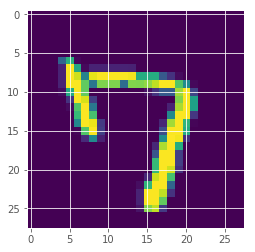

In [4]:
randi = np.random.randint(len(mnist.train.images))
plt.imshow(mnist.train.images[randi].reshape(28,28))
label = np.where(mnist.train.labels[randi]==1)
print('Label: {}' .format(int(label[0])))

# Weight and Bias Initalisation 

In [5]:
def weight_init(shape):
    initial= tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_init(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Convolution and Pooling Functions


In [6]:
def conv2d(x, W):
    return tf.nn.conv2d(x,W, strides=[1,1,1,1], padding='SAME')

def max_pooling_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

# Convolution and Fully Connected Layers

In [7]:
def conv_layer(input, channels_in, channels_out, name='conv'):
    with tf.name_scope(name):
        W = tf.Variable(tf.truncated_normal(shape = [5, 5, channels_in, channels_out], stddev=0.01), name = 'W')
        b = tf.Variable(tf.constant(0.1, shape = [channels_out]), name = 'b')
        conv = tf.nn.conv2d(input, W, strides=[1,1,1,1], padding='SAME')
        act = tf.nn.relu(conv + b)
        return tf.nn.max_pool(act, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def fc_layer(input, channels_in, channels_out, name = 'fc'):
    with tf.name_scope(name):
        W = tf.Variable(tf.truncated_normal(shape = [channels_in, channels_out], stddev=0.01), name = 'W')
        b = tf.Variable(tf.constant(0.1, shape = [channels_out]), name = 'b')
        return tf.nn.relu(tf.matmul(input, W) + b)
        
    

# Deep Network Version 1

In [8]:
# Conv > pool > conv > pool > dense > dropout > out 

def deepnn(x): 
    '''
    x: input tensor with dimensions (n, 784)
    
    returns (y, keep_prob)
    y: tensor of shape(n, 10)
    keep_prob: scalar placeholder for the probability of dropout
    '''
    
    # Reshape for convolution
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    
    # First Convolutional Layer
    W_conv1 = weight_init([5,5,1,32])
    b_conv1 = bias_init([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    
    # First Pooling Layer 
    h_pool1 = max_pooling_2x2(h_conv1)
    
    # Second Convolutional Layer
    W_conv2 = weight_init([5,5,32,64])
    b_conv2 = bias_init([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2)+b_conv2)
    
    # Second Pooling Layer 
    h_pool2 = max_pooling_2x2(h_conv2)
    
    
    # First Fully Connected Layer - after 2 round of downsampling, our 28x28 image
    # is down to 7x7x64 feature maps -- maps this to 1024 features.
    W_fc1 = weight_init([7*7*64, 1024])
    b_fc1 = bias_init([1024])
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    
    # Dropout 
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
    
    # Second FC, Output 
    W_fc2 = weight_init([1024, 10])
    b_fc2 = bias_init([10])
    
    y_conv = tf.matmul(h_fc1_drop, W_fc2) +  b_fc2
    return y_conv, keep_prob

# Deep Network Version 2

In [9]:
# Conv > pool > conv > pool > dense > dropout > out 

def deepnn(x): 
    '''
    x: input tensor with dimensions (n, 784)
    
    returns (y, keep_prob)
    y: tensor of shape(n, 10)
    keep_prob: scalar placeholder for the probability of dropout
    '''
    
    # Reshape for convolution
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    
    # First Conv and Pool Layer 
    h1 = conv_layer(x_image, 1, 32, 'conv1')
    # Second Conv and pool Layer
    h2 = conv_layer(h1, 32, 64, 'conv2')
    # Flatten 
    flattened = tf.reshape(h2, [-1, 7*7*64])
    # Fully Connected
    h3 = fc_layer(flattened, 7*7*64, 1024, 'fc1')
    # Dropout 
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h3, keep_prob)
    
    
    # Second FC, Output 
    W_fc2 = weight_init([1024, 10])
    b_fc2 = bias_init([10])
    y_conv = tf.matmul(h_fc1_drop, W_fc2) +  b_fc2
    return y_conv, keep_prob

# Building the Model


In [40]:
image_shape = 28
input_size = image_shape * image_shape
output_size =10

learning_rate = 0.0001
batch_size = 50

epoch = 20
epoch_size = 4000
n_steps = epoch * epoch_size 

# Create / Reset the graph
tf.reset_default_graph()

# Input Images and Target Output Classes
x = tf.placeholder(tf.float32, shape=[None, input_size])
y_ = tf.placeholder(tf.float32, shape=[None, output_size])

y_conv, keep_prob = deepnn(x)

# Note: tf.nn.softmax_cross_entropy_with_logits internally applies the softmax on the model's unnormalised model prediction and sums across all calsses 
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

# Train 
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

# Measurements 
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.arg_max(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Training Session


In [41]:
%%time
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# File Writer for TensorBoard 
writer = tf.summary.FileWriter('./temp/tensorboard/1')
writer.add_graph(sess.graph)

for step in range(n_steps+1):
    # Training
    batch = mnist.train.next_batch(batch_size)
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
    
    
    # Print outs
    if step%epoch_size==0:
             print("Epoch: {} Cross Entropy: {:6f} Accuracy: {:4.2f}% " .format(int(step/epoch_size), 
                cross_entropy.eval(feed_dict={x:batch[0], y_:batch[1], keep_prob: 1}),
                100*accuracy.eval(feed_dict={x:batch[0], y_:batch[1], keep_prob: 1})))
    

Epoch: 0 Cross Entropy: 2.252848 Accuracy: 24.00% 
Epoch: 1 Cross Entropy: 0.007936 Accuracy: 100.00% 
Epoch: 2 Cross Entropy: 0.014639 Accuracy: 100.00% 
Epoch: 3 Cross Entropy: 0.059866 Accuracy: 98.00% 
Epoch: 4 Cross Entropy: 0.024355 Accuracy: 98.00% 
Epoch: 5 Cross Entropy: 0.001586 Accuracy: 100.00% 
Epoch: 6 Cross Entropy: 0.001426 Accuracy: 100.00% 
Epoch: 7 Cross Entropy: 0.002080 Accuracy: 100.00% 
Epoch: 8 Cross Entropy: 0.000049 Accuracy: 100.00% 
Epoch: 9 Cross Entropy: 0.000106 Accuracy: 100.00% 
Epoch: 10 Cross Entropy: 0.000770 Accuracy: 100.00% 
Epoch: 11 Cross Entropy: 0.000008 Accuracy: 100.00% 
Epoch: 12 Cross Entropy: 0.000745 Accuracy: 100.00% 
Epoch: 13 Cross Entropy: 0.000157 Accuracy: 100.00% 
Epoch: 14 Cross Entropy: 0.000003 Accuracy: 100.00% 
Epoch: 15 Cross Entropy: 0.000028 Accuracy: 100.00% 
Epoch: 16 Cross Entropy: 0.000002 Accuracy: 100.00% 
Epoch: 17 Cross Entropy: 0.000070 Accuracy: 100.00% 
Epoch: 18 Cross Entropy: 0.000117 Accuracy: 100.00% 
Epoch:

# Predication Accuracy

In [42]:
print('Test Accuracy: {:4.2f}%' .format(100*accuracy.eval(feed_dict={x:mnist.test.images, y_:mnist.test.labels, keep_prob:1})))
h = tf.nn.softmax(y_conv)
predictions = h.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob:1})

Test Accuracy: 99.19%


# Display Predictions

In [43]:
def display_predictions(image, correct_label, softmax_values):
    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    img_ax = plt.subplot(1,2,1)
    plt.imshow(image.reshape(28,28))
    label = np.where(correct_label==1)
    img_ax.set_title(label[0])
    conf_ax = plt.subplot(1,2,2)
    index= range(0,10)
    plt.bar(index, softmax_values)
    conf_ax.set_ylim(0,1)
    conf_ax.set_ylabel('Confidence')
    conf_ax.set_xlabel('Class')
    conf_ax.set_title('Predications')
    return

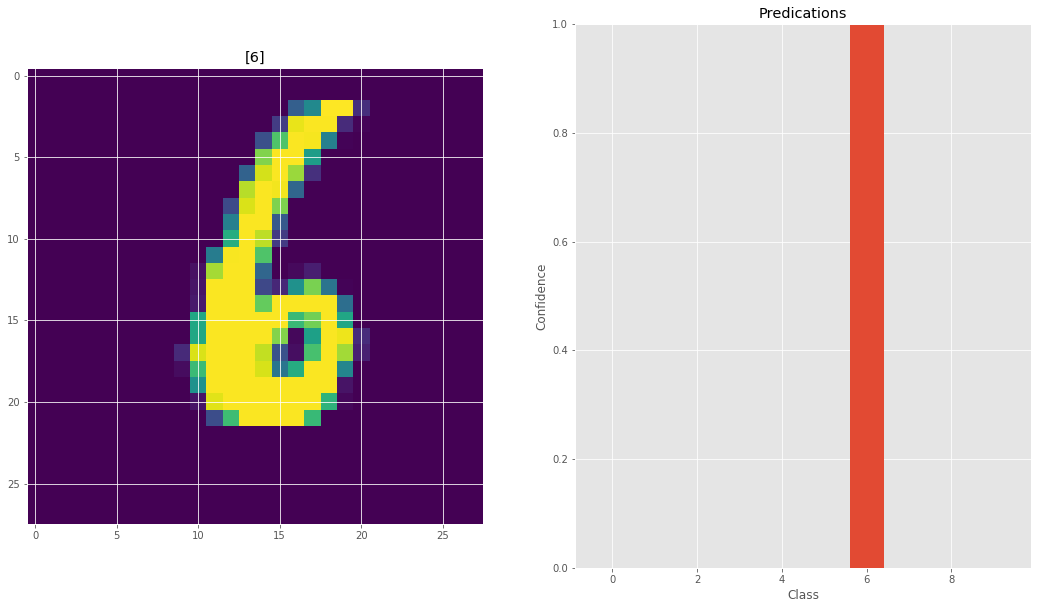

In [44]:
randi = np.random.randint(len(mnist.test.images))
display_predictions(mnist.test.images[randi], mnist.test.labels[randi], predictions[randi])

In [38]:
correctness = correct_prediction.eval(feed_dict={x:mnist.test.images, y_:mnist.test.labels, keep_prob:1})
incorrect_index = np.where(correctness==False)
incorrect_index = incorrect_index[0]
print('Number of Incorrect Predictions: {}' .format(len(incorrect_index)))

Number of Incorrect Predictions: 84


# Display All Incorrect Predictions


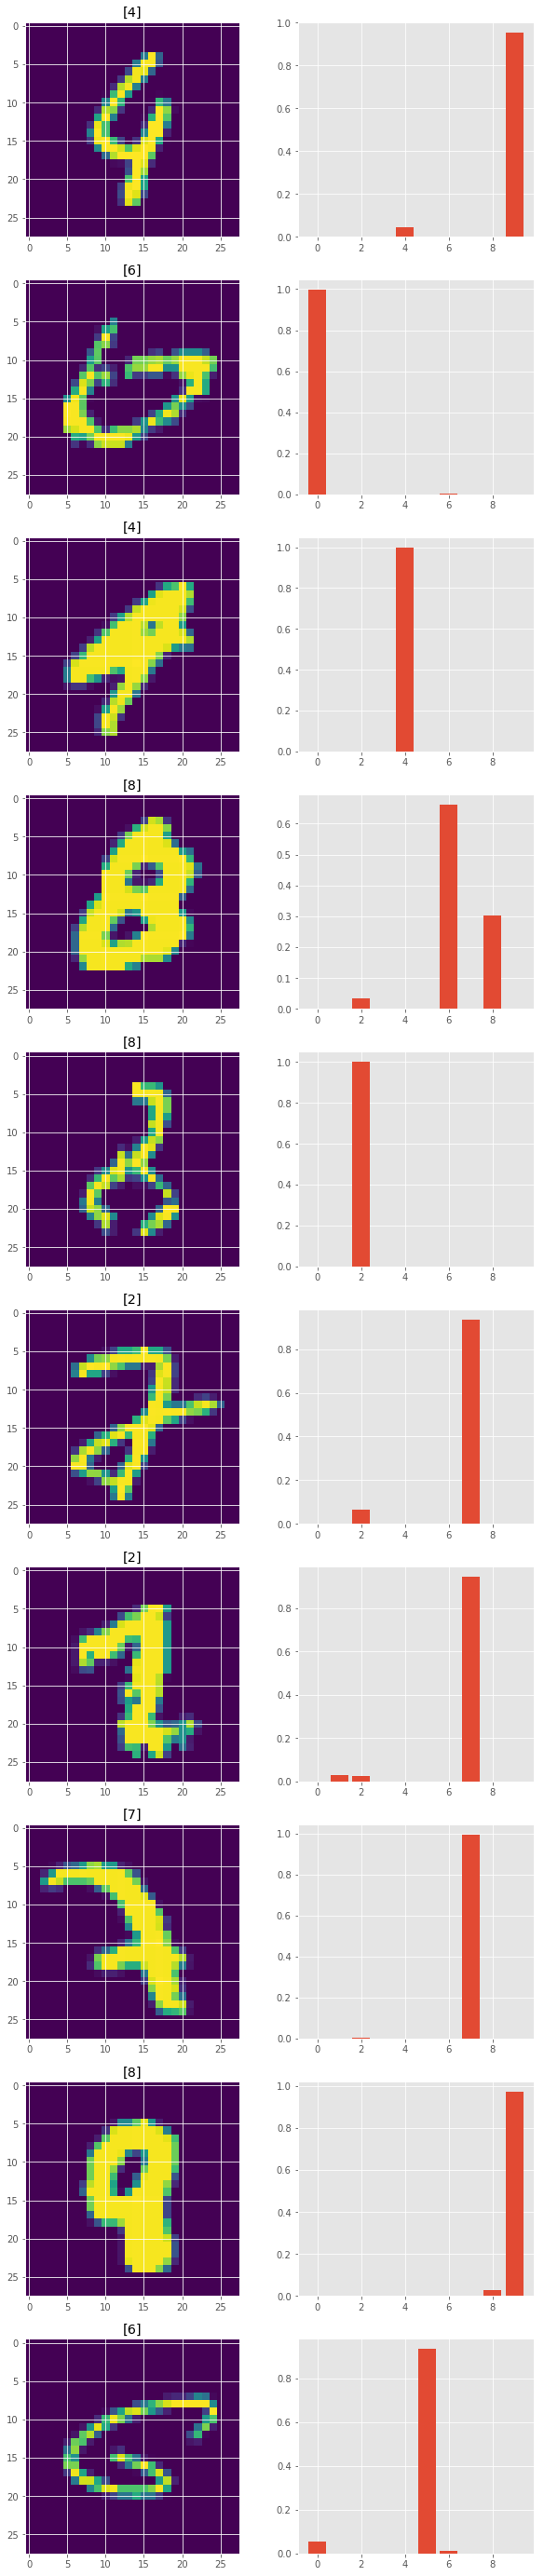

In [45]:
#
max_disp = 10
fig, axarr = plt.subplots(max_disp, 2)
fig.set_size_inches(10, max_disp*5)
for i in range(0, max_disp):
    index = incorrect_index[i]
    axarr[i, 0].imshow(mnist.test.images[index].reshape(28,28))
    label = np.where(mnist.test.labels[index]==1)
    axarr[i, 0].set_title(label[0])
    #http://matplotlib.org/examples/pylab_examples/subplots_demo.html
    axarr[i,1].bar(range(0,10), predictions[index])